# Mars Entry-Descent-Landing Mission Scenario

This case study demonstrates using Pacti for formalizing a simplified version of a Mars Entry-Descent-Landing mission scenario based on the following paper: [R. Prakash et al. 2008](#ref1)
and the Mars 2020 EDL timeline from https://mars.nasa.gov/mars2020/timeline/landing/entry-descent-landing/

![](https://mars.nasa.gov/internal_resources/961/)

In [1]:
from pacti.iocontract import *
from pacti.terms.polyhedra import *
import matplotlib.pyplot as plt

In [2]:
# The rate of deacceleration during atmospheric entry.
atmospheric_v_entry = 20000.0
atmospheric_v_exit = 1600.0
atmospheric_t_entry = 0.0
atmospheric_t_exit = 90.0
atmospheric_min_deacceleration = abs((atmospheric_v_entry - atmospheric_v_exit) / (atmospheric_t_entry - atmospheric_t_exit))
print(f"atmospheric_min_deacceleration={atmospheric_min_deacceleration}")

atmospheric_entry_contract = PolyhedralContract.from_string(
    InputVars=[
      "t0",           # time @ entry
      "v0"            # velocity @ entry
    ],
    OutputVars=[
      "t1",           # time @ exit
      "v1"            # velocity @ exit
    ],
    assumptions=[
      # time @ entry
      f"t0 <= {atmospheric_t_entry}",

      # velocity @ entry
      f"v0 <= {atmospheric_v_entry}"
    ],
    guarantees=[
      # upper limit on atmospheric entry duration
      f"t0 - t1 = {atmospheric_t_entry - atmospheric_t_exit}",

      # "v1 <= v0 - (t1 - t0)*atmospheric_min_deacceleration"
      f"v1 - v0 + {atmospheric_min_deacceleration} t1 - {atmospheric_min_deacceleration} t0 <= 0"

      # If the above is replaced with this, plotting will produce an error: ValueError: Assumptions are unfeasible
      # f"v0 - v1 + {atmospheric_min_deacceleration} t1 - {atmospheric_min_deacceleration} t0 <= 0"
    ])

print(atmospheric_entry_contract)

atmospheric_min_deacceleration=204.44444444444446
InVars: [t0, v0]
OutVars:[t1, v1]
A: [
  t0 <= 0.0
  v0 <= 20000.0
]
G: [
  t0 - t1 = -90.0
  -204.44444444444446 t0 + 204.44444444444446 t1 - v0 + v1 <= 0.0
]


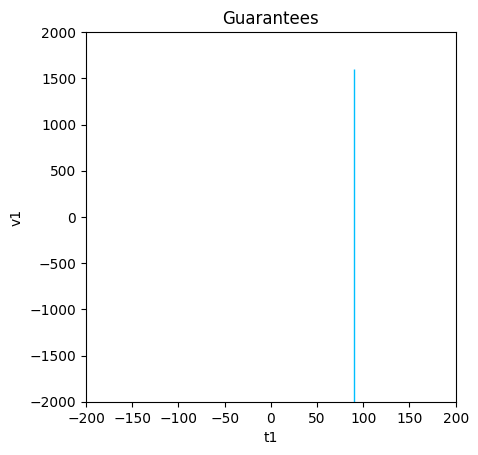

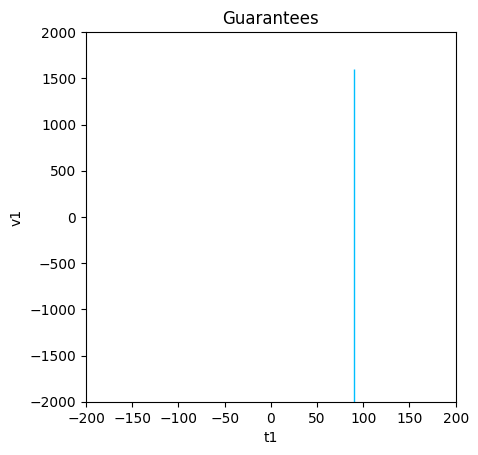

In [17]:
plot_guarantees(
    contract=atmospheric_entry_contract,
    x_var=Var("t1"),
    y_var=Var("v1"),
    var_values={
        Var("t0"):atmospheric_t_entry,
        Var("v0"):atmospheric_v_entry
    },
    x_lims=(-200,200),
    y_lims=(-2000,2000)
    # x_lims=(atmospheric_t_exit*0.9,atmospheric_t_exit*1.1),
    # y_lims=(atmospheric_v_exit*0.7, atmospheric_v_exit*1.1)
)

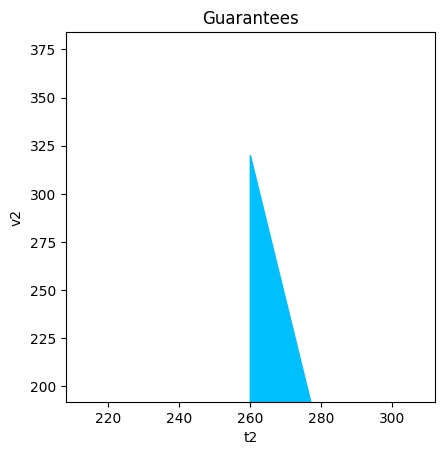

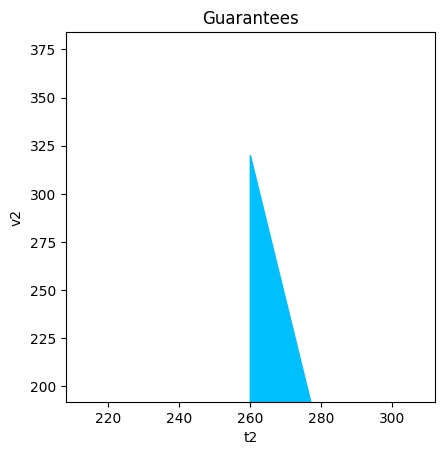

In [5]:
plot_guarantees(
    contract=parachute_deployment_contract,
    x_var=Var("t2"),
    y_var=Var("v2"),
    var_values={
        Var("t1"):parachute_t_entry,
        Var("v1"):parachute_v_entry
    },
    x_lims=(parachute_t_exit*0.8, parachute_t_exit*1.2),
    y_lims=(parachute_v_exit*0.6, parachute_v_exit*1.2)
)

In [6]:
mission_scenario_before_powered_descent = atmospheric_entry_contract.compose(parachute_deployment_contract)
print(mission_scenario_before_powered_descent)

InVars: [t0, v0]
OutVars:[t2, v2]
A: [
  t0 <= 0.0
  v0 <= 20000.0
]
G: [
  t0 - t2 <= -260.0
  -7.52941176470588 t0 + 7.52941176470588 t2 - v0 + v2 <= -17722.3529411765
]


In [27]:
skycrane_t_entry = 400.0
skycrane_v_entry = 2.7

mission_scenario_before_skycrane = PolyhedralContract.from_string(
    InputVars=[
      "t0",           # entry time
      "v0"            # entry velocity
    ],
    OutputVars=[
      "t3",           # exit time
      "v3"            # exit velocity
    ],
    assumptions=[
      # time @ entry
      f"t0 <= {atmospheric_t_entry}",

      # velocity @ entry
      f"v0 <= {atmospheric_v_entry}"
    ],
    guarantees=[
      # upper limit on duration before skycrane interface
      f"t0 - t3 <= -{skycrane_t_entry}",

      # "v3 <= {skycrane_v_entry}"
      f"v3 <= {skycrane_v_entry}"
    ])

print(mission_scenario_before_skycrane)



InVars: [t0, v0]
OutVars:[t3, v3]
A: [
  t0 <= 0.0
  v0 <= 20000.0
]
G: [
  t0 - t3 <= -400.0
  v3 <= 2.7
]


In [28]:
induced_powered_descent_requirement = mission_scenario_before_skycrane.quotient(mission_scenario_before_powered_descent)
print(induced_powered_descent_requirement)

InVars: [t2, v2]
OutVars:[t3, v3]
A: [
  7.52941176470588 t2 + v2 <= 2277.64705882353
]
G: [
  t2 - t3 <= -140.0
  v3 <= 2.7
]


In [30]:
plot_guarantees(
    contract=induced_powered_descent_requirement,
    x_var=Var("t3"),
    y_var=Var("v3"),
    var_values={
        Var("t2"):parachute_t_exit,
        Var("v2"):parachute_v_exit
    },
    x_lims=(0,400),
    # x_lims=(parachute_t_exit*0.8, parachute_t_exit*1.2),
    y_lims=(-100,100)
    # y_lims=(skycrane_v_entry*0.6, parachute_v_exit*1.2)
)

ValueError: Assumptions are unfeasible

## References

<a id="ref1"></a> __[R. Prakash et al. 2008](https://ieeexplore.ieee.org/abstract/document/4526283)__

R. Prakash et al., "Mars Science Laboratory Entry, Descent, and Landing System Overview," 2008 IEEE Aerospace Conference, Big Sky, MT, USA, 2008, pp. 1-18, doi: 10.1109/AERO.2008.4526283.
